# Federated Learning Tutorial: Launching the Client 2


<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning client for running a federated learning experiment with two clients and one central server. The server launching code is available at [here](https://colab.research.google.com/drive/1tlMNB4ryfRP2wc1qHk0HQeLyxlRO0q1c#scrollTo=8s2dMKDysMmI). Please make sure you first launch the server before launching this client. The launching notebook for the first client is available at [here](https://colab.research.google.com/drive/1rASaQDkboT9WxjrsyWGqFvQEQ7kXtgFN#scrollTo=QEMfYk5m7Ie2).

This example will train a simple ResNet using the AI-READI dataset partitioned into two cleint splits in a federated manner to predict the device of the collected images.

## 0. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

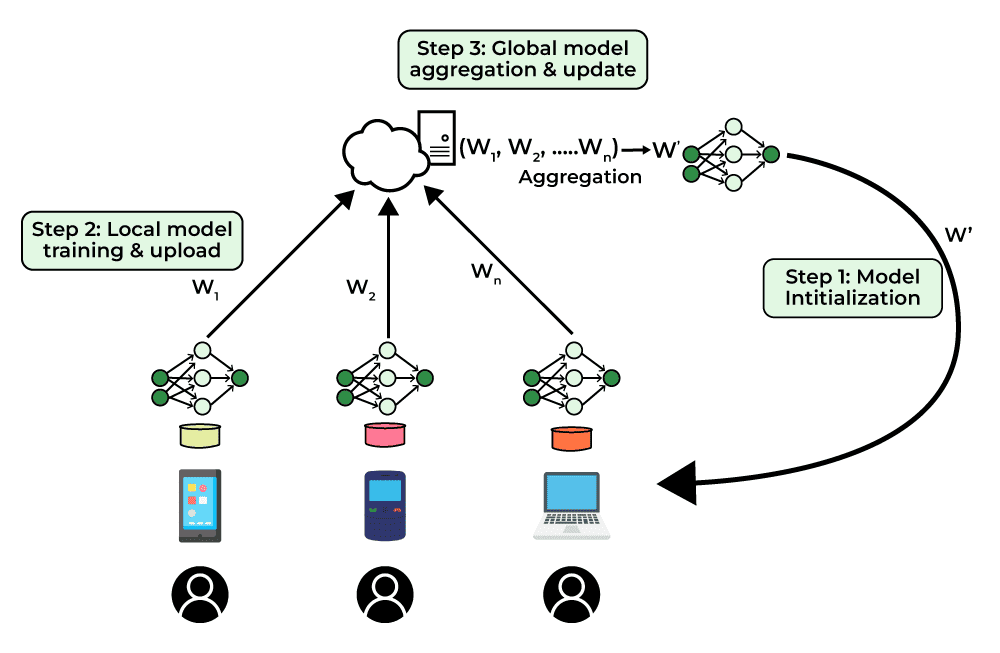

## 1. Install `appfl`

User needs to first install the `appfl` package by the following commands. Since we already have APPFL installed in our workspacewe will skip it.

`pip install appfl`

In [ ]:
import os
import warnings

warnings.filterwarnings('ignore')
# setting the current working directory
target_directory = '/home/jupyter/lab/APPFL/examples'

os.chdir(target_directory)

## 3. Create federated learning client agent from configurations

We need to update the `server_uri` to the URL obtained from the **server** notebook.

#### Steps:

- ##### Obtain the `server` URL:
  - For example, the server URL from the server notebook is `172.31.79.131:50051`.

- ##### Update the code:
  - Replace the placeholder in the following line with the actual `server` URL obtained.

  - Update the code as follows:
`client_agent_config.comm_configs.grpc_configs["server_uri"] = "172.31.79.131:50051"`

In the client configurations, it has four main parts:

- `client_id`: A unique identifier for the client
- `train_configs`: Client-specific training related configruations, such as the device and logging directories
- `data_configs`: Information about the dataloader file that can create a PyTorch dataset for the AI-READI data
- `comm_configs`: Information needed to connect to the server notebook

In [ ]:
from omegaconf import OmegaConf
from appfl.agent import ClientAgent
client_agent_config = OmegaConf.load("./resources/configs/aireadi/client_2_ec2.yaml")
client_agent_config.comm_configs.grpc_configs["server_uri"] = "172.31.79.131:50051" # Reminder: Replace this with the URI you got from the server notebook!
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")
client_agent = ClientAgent(client_agent_config=client_agent_config)

## 4. Visualizing the data distribution

Here we see the data distribution on each device type that is being used for the training

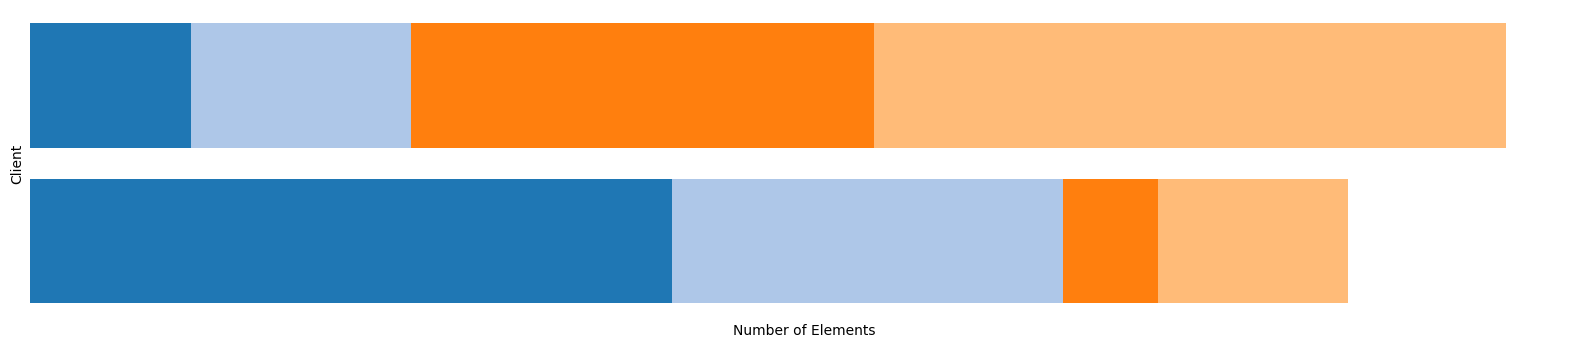

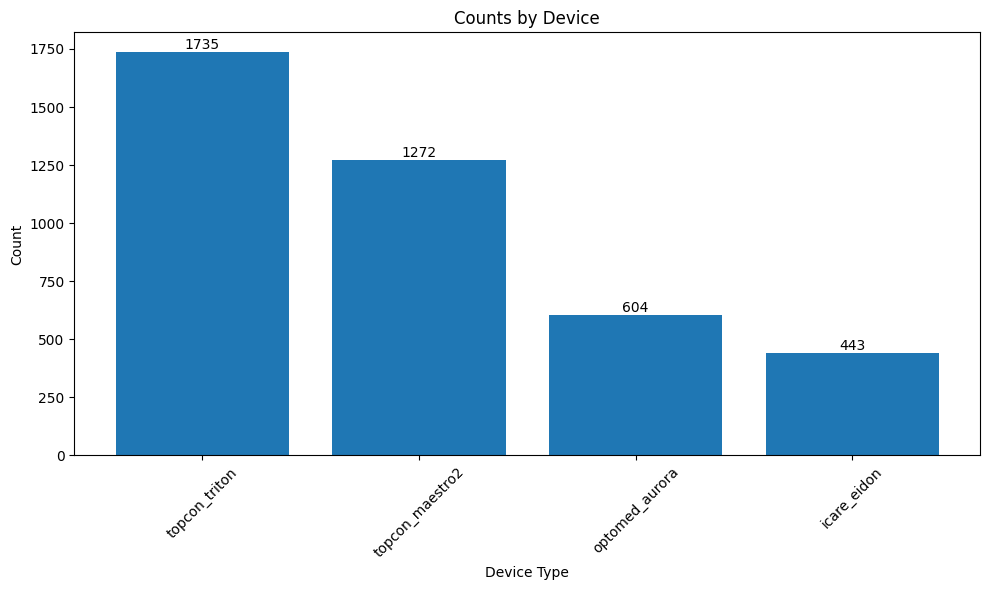

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

train_distribution = client_agent.train_dataset.label_counts()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(train_distribution.keys(), train_distribution.values())

plt.xlabel('Device Type')
plt.ylabel('Count')
plt.title('Counts by Device')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()

## 5. Create Client Communicator

Now, we create a grpc client communicator for sending various requests to the server.

In [ ]:
from appfl.comm.grpc import GRPCClientCommunicator

client_communicator = GRPCClientCommunicator(
    client_id=client_agent.get_id(),
    **client_agent_config.comm_configs.grpc_configs,
)

## 6. Start training loop by sending requests to server.

In this main training loop, it has four main types of request to send to the server:

(1) `get_configuration()`: Get general client configurations for local training

(2) `get_global_model(init_model=True)`: Get the initial global model for training

(3) `update_global_model()`: Send the trained local model to update the global model, and get the updated model back for further local training

(4) `invoke_custom_action(action="close_connection")`: Close the connection with the server

In [ ]:
# Get general client configurations
client_config = client_communicator.get_configuration()
client_agent.load_config(client_config)

# Get initial global model parameters
init_global_model = client_communicator.get_global_model(init_model=True)
client_agent.load_parameters(init_global_model)

# Start local training loop
while True:
    client_agent.train()
    local_model = client_agent.get_parameters()
    if isinstance(local_model, tuple):
        local_model, metadata = local_model[0], local_model[1]
    else:
        metadata = {}
    new_global_model, metadata = client_communicator.update_global_model(
        local_model, **metadata
    )
    if metadata["status"] == "DONE":
        break
    client_agent.load_parameters(new_global_model)

# Close connection
client_communicator.invoke_custom_action(action="close_connection")